In [1]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
from matplotlib import pyplot as plt
import keras.backend as K
from scipy.misc import imresize, imsave
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from keras.preprocessing.image import array_to_img, img_to_array, load_img
%matplotlib inline

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [3]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [4]:
def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

In [5]:
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

In [6]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [53]:
def grad_cam(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    print(target_layer)
    model.add(Lambda(target_layer,
                     output_shape = model.output_shape))

    loss = K.sum(model.layers[-1].output)
    print(loss)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = cv2.resize(cam, (224, 224))

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    print(image.shape)
    image -= np.min(image)
    image = image.max()
    image = np.minimum(image, 255)

    cam_heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    combined = np.float32(cam_heatmap) + np.float32(image)
    combined = 255 * combined / np.max(combined)
    return np.uint8(combined), cam_heatmap

In [54]:
def grad_cam_2(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = model.output_shape))

    loss = K.sum(model.layers[-1].output)
    print(loss)
    conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [55]:
preprocessed_input = load_img("/home/deploy/pramit/deep_learning/data/convertible.jpg")

In [56]:
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [57]:
def image_resizing(img_file):
    img_as_arry = img_to_array(img_file)
    resized = imresize(img_as_arry, (224, 224))
    resized = np.expand_dims(resized, axis=0)
    an_img = resized
    return an_img

(1, 224, 224, 3)


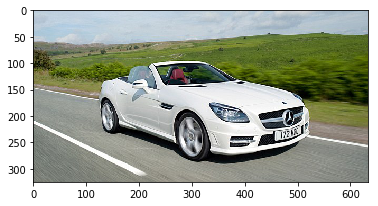

In [58]:
plt.imshow(preprocessed_input)
transformed_img = image_resizing(preprocessed_input)
print(transformed_img.shape)

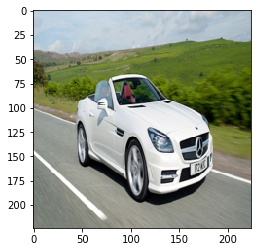

In [59]:
plt.imshow(transformed_img[0])

In [60]:
predictions = model.predict(transformed_img)
top_pred = decode_predictions(predictions)
print(top_pred[0][0:5])

[(u'n04285008', u'sports_car', 0.52164388), (u'n03100240', u'convertible', 0.24690321), (u'n04037443', u'racer', 0.18329015), (u'n02974003', u'car_wheel', 0.024107343), (u'n03930630', u'pickup', 0.009816491)]


In [61]:
predicted_class_index = np.argmax(predictions)
print(predicted_class_index)
loss = K.mean(model.output[:, 481])
print(loss)

817
Tensor("Mean_9:0", shape=(), dtype=float32)


In [65]:
#c, heatmap = grad_cam(model, transformed_img, predicted_class+1, "block5_conv3")
cam1, heatmap = grad_cam(model, transformed_img, 481, "block5_pool")
cv2.imwrite("gradcam_car_wheel.jpg", cam1)
print(heatmap.shape)

<function <lambda> at 0x7fb07eece6e0>
Tensor("Sum_8:0", shape=(), dtype=float32)
(224, 224, 3)
(224, 224, 3)


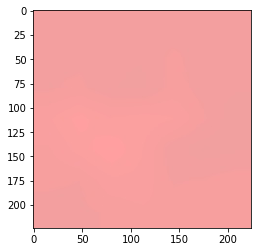

In [66]:
plt.imshow(load_img("gradcam_car_wheel.jpg"))

In [19]:
heatmap[np.newaxis, ...].shape

(1, 224, 224, 3)

In [20]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([transformed_img, 0])
gradcam = saliency[0] * heatmap[np.newaxis, ...]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

True

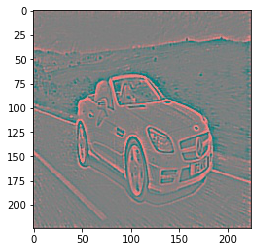

In [21]:
plt.imshow(load_img("guided_gradcam.jpg"))